In [ ]:
# Start writing code here...

In [ ]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression



from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from lib.viz import draw_histogram, create_silhoutte_cluster_viz
from lib.unsupervised import kmeans_parameters_search

%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
RANDOM_SEED = 42

## Load numpy arrays and dataframes from pickle files

In [ ]:
with open('train_test_dict.pickle', 'rb') as file:
        train_test_dict = pickle.load( file)
X_train_impute = train_test_dict['X_train_impute']
X_test_impute = train_test_dict['X_test_impute']
y_train = train_test_dict['y_train']
y_test = train_test_dict['y_test']

with open('X_train_impute_df.pkl', 'rb') as file:
        X_train_impute_df = pickle.load( file)
with open('X_test_impute_df.pkl', 'rb') as file:
        X_test_impute_df = pickle.load( file)


## Understand the distribution of the target

In [ ]:
draw_histogram(pd.DataFrame(y_train.reset_index()), "GSE_GWE" ) 

alt.LayerChart(...)

### Baseline
   - Distribution of the target and statistics such as mean and median 
   - It can be observed below that the target has a [left skewed distribution](https://stats.stackexchange.com/questions/11351/left-skewed-vs-symmetric-distribution-observed/11352#11352) with most well of the groundwater depth less that 200
   - The score of this regressor is very low : R-squared of the prediction = -0.057
   - The r-squared isnegative and this indicates that the the sum-of-squares of the residuals from the model (SSres) is larger than the sum-of-squares from the horizontal line (median) (SStot).
   - R-squared is computed as 1−SSres/SStot. (here, SSres = residual error)When SSres is greater than SStot, that equation could compute a negative value for R-squared, if the value of the coefficient is greater than 1.

In [ ]:
def predict_score_base_regressors(reg, X, y, name_of_regressor:str):
    reg.fit(X,y)
    print(f"Prediction from {name_of_regressor} is : {reg.predict(X)}")
    print(f"Train Set Regression Score from {name_of_regressor} is : {reg.score(X,y)}")

In [ ]:
dummy_regr = DummyRegressor(strategy="median")
lreg = LinearRegression()
rreg = Ridge()
lasreg = Lasso()

predict_score_base_regressors(dummy_regr, X_train_impute, y_train, "Dummy Regressor")
predict_score_base_regressors(lreg, X_train_impute, y_train, "Linear Regressor")
predict_score_base_regressors(rreg, X_train_impute, y_train, "Ridge Regressor")
predict_score_base_regressors(lasreg, X_train_impute, y_train, "Lasso Regressor")



Prediction from Dummy Regressor is : [135.47275 135.47275 135.47275 ... 135.47275 135.47275 135.47275]
Train Set Regression Score from Dummy Regressor is : -0.057090827770692965
Prediction from Linear Regressor is : [124.02559817 111.4254949   97.06014597 ... 324.66703306 320.78229306
 320.82513735]
Train Set Regression Score from Linear Regressor is : 0.5595387697659555
Prediction from Ridge Regressor is : [122.36096044 106.85415893  97.9512874  ... 315.23472464 310.35964295
 309.11776963]
Train Set Regression Score from Ridge Regressor is : 0.5116318808253719
Prediction from Lasso Regressor is : [100.4447834   83.95961512  79.61023103 ... 223.31467851 215.08817061
 214.40654012]
Train Set Regression Score from Lasso Regressor is : 0.3775917065499912


## Using Unsupervised Learning to instrument feature to improve Supervised Learning

- Both Silhouette score (closer to 1 is better) and  davies_bouldin_score (lower is better) emphasize the distance between clusters 
- intertia tries to minimize the distane from point to center (lower is better) 
- For this dataset the davies_bouldin_score as well as inertia drops with the rise in number of clusters but silhouette score is higher at k=2

In [ ]:
# Assume the number of clusters
kmeans_score_df = kmeans_parameters_search(X_train_impute, random_seed= RANDOM_SEED)
print (f"Top clustering Scores : {kmeans_score_df.loc[0]}")

Top clustering Scores : k                              2.000000
davies_bouldin_score           1.797506
calinski_harabasz_score      804.008961
silhouette_score               0.271402
sum_squared_distances      39708.596250
Name: 0, dtype: float64


In [ ]:
#kmeans_score_df

## [Silhoutte Score Visualization](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as)
1.  near +1 indicate that the sample is far away from the neighboring clusters. 
2. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
3. negative values indicate that **those samples might have been assigned to the wrong cluster.**
4. Also from the thickness of the silhouette plot the cluster size can be visualized. 

For n_clusters = 2 The average silhouette_score is : 0.27140214446988076
For n_clusters = 3 The average silhouette_score is : 0.2168357132262969
For n_clusters = 4 The average silhouette_score is : 0.20460163319979777
For n_clusters = 5 The average silhouette_score is : 0.2117219104592868
For n_clusters = 6 The average silhouette_score is : 0.22374932500859115


<module 'matplotlib.pyplot' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/pyplot.py'>

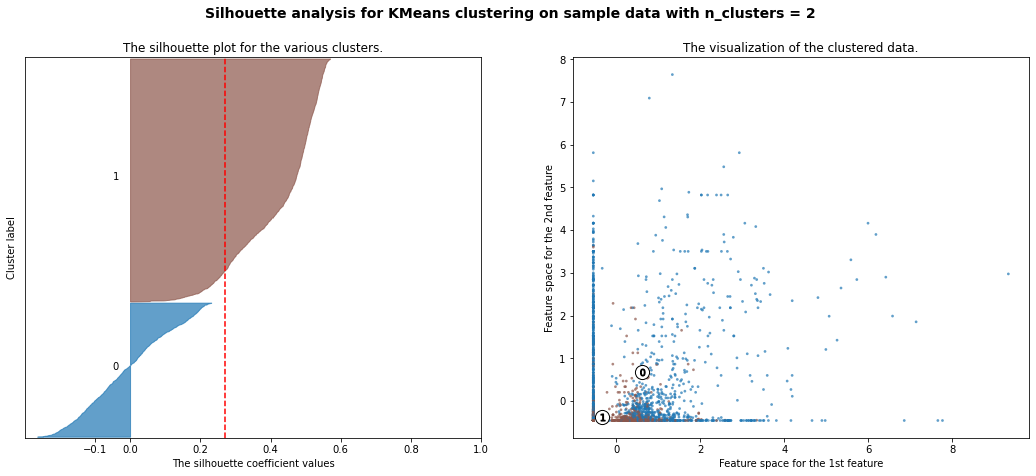

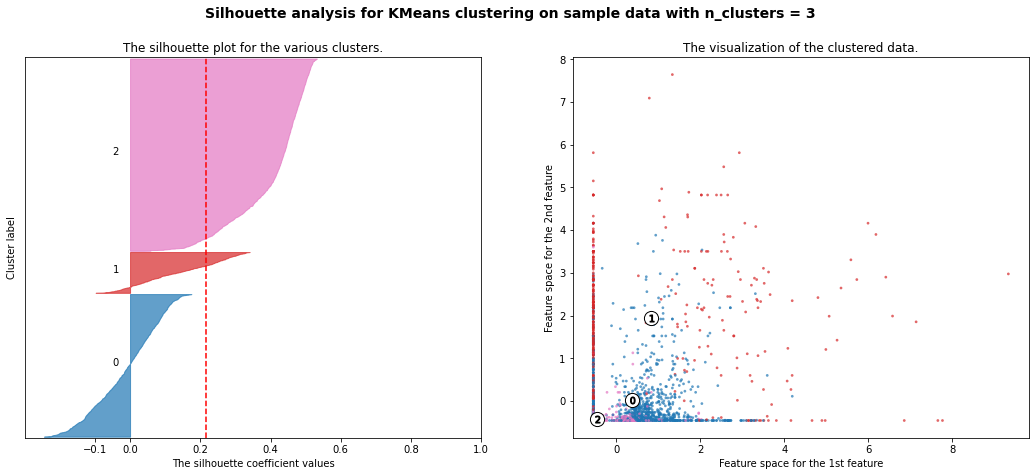

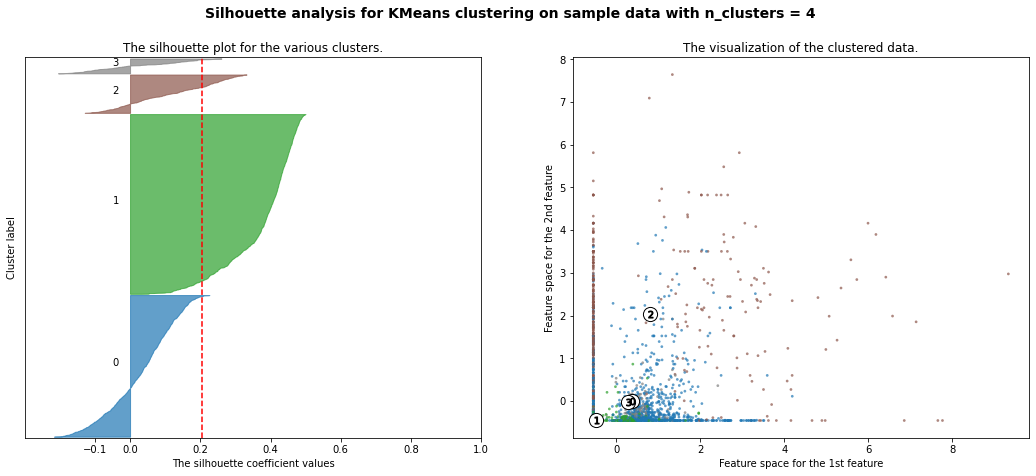

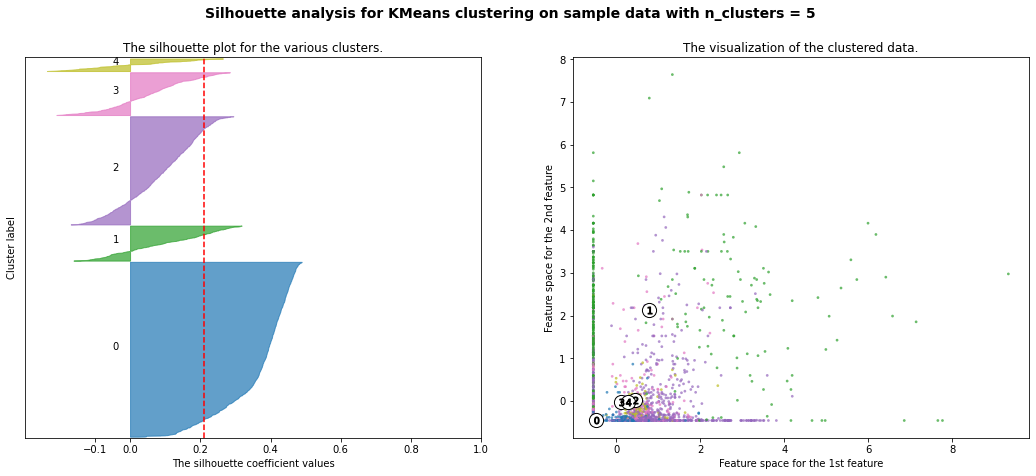

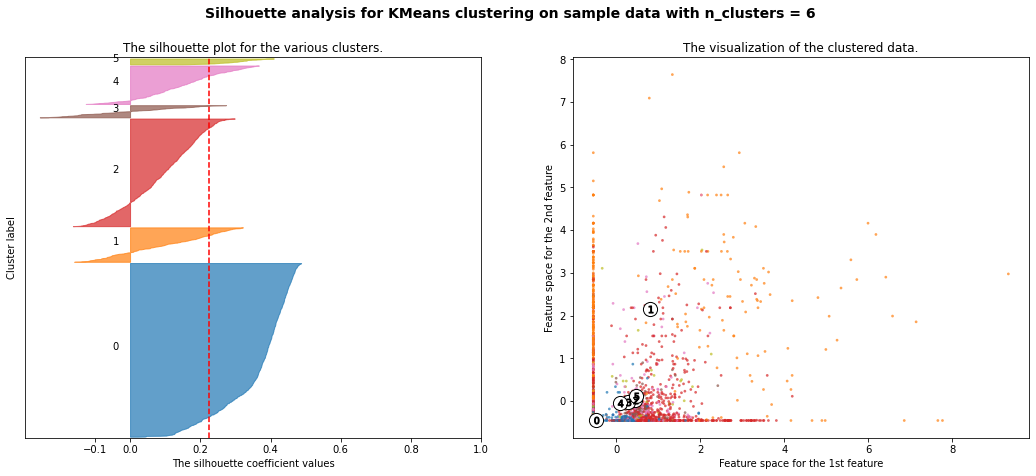

In [ ]:
create_silhoutte_cluster_viz(X_train_impute, RANDOM_SEED)

### Observations from clustering scores and visualizations

1. The scores indicate that 2 or 3 clusters will provide the best scores. The Silhouette score is low ~0.22 
2. The visualization show that the second cluster onwards, the data points are so scattered that they may have been incorrectly assigned  into a cluster.This causes the score to be negative and so we see negative scores for clusters more than 1.
3. The clusters are not evenly sized (thickness along Y-axis)


### Observations from clustering on the training set

1. The cluster do not include all years of a township range. There is no pattern as to which tR and years are inclluded in a cluster





## Adding KMeans clustering label as feature

In [ ]:
train_labels.shape

(3346,)

In [ ]:
def add_cluster_label(X_train_impute_df, X_test_impute_df, n_clusters, random_seed = RANDOM_SEED):
    kclf = KMeans(n_clusters = n_clusters, random_state=random_seed)
    kclf.fit(X_train_impute_df.values)

    train_labels = kclf.labels_
    test_labels = kclf.predict(X_test_impute_df.values)


    X_train_cluster_df = X_train_impute_df.copy()
    X_test_cluster_df = X_test_impute_df.copy()

    X_train_cluster_df['km_label'] = train_labels
    X_test_cluster_df['km_label'] = test_labels
    return X_train_cluster_df, X_test_cluster_df 



In [ ]:
# cluster_0 = X_train_cluster_df[X_train_cluster_df['km_label']==0].copy()
# cluster_1 = X_train_cluster_df[X_train_cluster_df['km_label']==1].copy()
#cluster_0.reset_index(inplace=True)
# cluster_1.reset_index(inplace=True)

#cluster_0[cluster_0['TOWNSHIP_RANGE'] == 'T01N R08E']

###  Generative versus Declarative algorithms

### Random searching to narrow down possibilities to provide to GridSearch

Regularization and Generalization for [Lasso](https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression)

When it comes to training models, there are two major problems one can encounter: overfitting and underfitting.

- Overfitting happens when the model performs well on the training set but not so well on unseen (test) data.
- Underfitting happens when it neither performs well on the train set nor on the test set.
Particularly, regularization is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set performances. With regularization, the number of features used in training is kept constant, yet the magnitude of the coefficients is reduced.


**Ridge and Lasso** 

**Lasso Regression for Model Selection**
Lasso is short for Least Absolute Shrinkage and Selection Operator, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression. 
Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

**Ridge regression** puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square.
Minimizes objective function:
||y - Xw||^2_2 + alpha * ||w||^2_2


**Scores**
[Negative Mean Absolute Error](https://stackoverflow.com/questions/55786121/what-is-the-negative-mean-absolute-error-in-scikit-learn#:~:text=As%20its%20name%20implies%2C%20negative,than%20a%20value%20of%20%2D3.0%20.) Smaller the better

In [ ]:
rfreg = RandomForestRegressor(
    max_depth=2, n_estimators=200, random_state=RANDOM_SEED
).fit(X_train_impute, y_train)
print(f"Train set score: {rfreg.score(X_train_impute, y_train)}")
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
print(f"Test set score:{rfreg.score(X_test_impute, y_test)}") # without duration = -0.601225986040484

Train set score: 0.373097701276752
Test set score:-0.03730173138387993


In [ ]:
# random search linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

model = Lasso()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
# define search space
space = dict()

#space["solver"] = ["svd", "cholesky", "lsqr", "sag"]
#space["solver"] = ["svd"]
space["alpha"] =  [ 1,0.1,0.01,0.001,0.0001]    #loguniform(1e-5, 100)
space["fit_intercept"] = [True, False]
# define search
search = RandomizedSearchCV(
    model,
    space,
    n_iter= 100,  #500,
    scoring= 'r2',    #"neg_median_absolute_error",‘neg_root_mean_squared_error’
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_SEED,
)
# execute search
train_result = search.fit(X_train_impute, y_train)
# summarize result
print("Best Score: %s" % train_result.best_score_)
print("Best Hyperparameters: %s" % train_result.best_params_)


/root/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best Score: 0.5351705218917426
Best Hyperparameters: {'fit_intercept': True, 'alpha': 0.001}
/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1134283.8239121512, tolerance: 5521.090684564098
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
alpha = 0.5
loop = 44
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=loop, learning_rate=alpha, random_state=RANDOM_SEED, init="zero"
)
gbrt.fit(X_train_impute, y_train)
gbrt.loss
y_pred = gbrt.predict(X_test_impute)
r2GBRT = metrics.r2_score(y_test, y_pred)
print("GBT: R^2 = ", r2GBRT)


GBT: R^2 =  -0.43648030010048555


In [ ]:
from  sklearn.svm import SVR

### Support Vector Machine Regressor

- We will be choosing the parameters first in this case and then run the regression with chosen parameters

In [ ]:
## Commenting out code since the best parameters have been found
param_grid = [
    {
        "C": [0.5, 1, 10, 100],
        "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
        "kernel": ["linear", "rbf"],
    }
]

optimal_params = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)
optimal_params.fit(X_train_impute, y_train)
print(optimal_params.best_params_)
#{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
svmreg = SVR(C= 100, gamma= 0.01, kernel= 'rbf')
svmreg.fit(X_train_impute, y_train)
print (f"Training Score : {svmreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {svmreg.score(X_test_impute, y_test)}")


Training Score : 0.4618833343933596
Testing Score : 0.15005476507505444


In [ ]:
#14 clusters (best davies_bouldin_score) gives a marginally better train score than 2 clusters  and same score for test set
X_train_cluster_df, X_test_cluster_df = add_cluster_label(
    X_train_impute_df, X_test_impute_df, n_clusters=2, random_seed=RANDOM_SEED
)
svmreg = SVR(C=100, gamma=0.01, kernel="rbf")
svmreg.fit(X_train_cluster_df.values, y_train)
print(f"Training Score : {svmreg.score(X_train_cluster_df.values, y_train)}")
print(f"Testing Score : {svmreg.score(X_test_cluster_df, y_test)}")


Training Score : 0.47802685201778694
/root/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
Testing Score : 0.15913653743251


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
# params = {'n_neighbors':[20, 20, 50, 100, 300]}

# knn = KNeighborsRegressor()

# model = GridSearchCV(knn, params, cv=5)
# model.fit(X_train_impute,y_train)
# model.best_params_
#{'n_neighbors': 100}

In [ ]:
knnreg = KNeighborsRegressor(n_neighbors=100)
knnreg.fit(X_train_impute, y_train)
print (f"Training Score : {knnreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {knnreg.score(X_test_impute, y_test)}")

Training Score : 0.46663457919327955
Testing Score : 0.039350703259104836


#Ideas
1. Drop features such as vegetation and crops and soil
2. Add K Means clustering results

In [ ]:
#https://community.deepnote.com/c/ask-anything/i-m-seeing-an-increasing-amount-of-packages-that-cannot-be-installed-due-to-version-mismatches-with-shared-libraries-set-up-by-deepnote-s-environment#comment_wrapper_6736171
!pip install pycaret[full] 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 43.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting require

In [ ]:
#This might need restart of the kernel
from pycaret.regression import *

In [ ]:
[col for col in X_train_impute_df if not (col.startswith('SOIL') or col.startswith('VEGETATION') or col.startswith('CROP'))]

['TOTALDRILLDEPTH_AVG',
 'WELLYIELD_AVG',
 'STATICWATERLEVEL_AVG',
 'TOPOFPERFORATEDINTERVAL_AVG',
 'BOTTOMOFPERFORATEDINTERVAL_AVG',
 'TOTALCOMPLETEDDEPTH_AVG',
 'POPULATION_DENSITY',
 'PCT_OF_CAPACITY',
 'GROUNDSURFACEELEVATION_AVG',
 'AVERAGE_YEARLY_PRECIPITATION',
 'WELL_COUNT_AGRICULTURE',
 'WELL_COUNT_DOMESTIC',
 'WELL_COUNT_INDUSTRIAL',
 'WELL_COUNT_PUBLIC']

In [ ]:
#  14 clusters (best davies_bouldin_score) gives a marginally better train score than 2 clusters  and same score for test set
X_train_cluster_df, X_test_cluster_df = add_cluster_label(
    X_train_impute_df, X_test_impute_df, n_clusters=2, random_seed=RANDOM_SEED
)


train_cluster_data = pd.concat([X_train_cluster_df, y_train], axis=1)
test_cluster_data = pd.concat([X_test_cluster_df, y_test], axis=1)


In [ ]:
from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_cluster_exp = setup(train_cluster_data
                        , target='GSE_GWE',
                        train_size=1.0,
                        test_data= test_cluster_data,
                        preprocess=False, session_id=RANDOM_SEED,
                       log_experiment=True, experiment_name="water_depth_cluster_1")

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 81)"
3,Missing Values,False
4,Numeric Features,80
5,Categorical Features,0
6,Transformed Train Set,"(3346, 80)"
7,Transformed Test Set,"(478, 80)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/06/19 19:35:02 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_cluster_1' does not exist. Creating a new experiment.


In [ ]:
%matplotlib inline
#creating a model
lr = create_model('lr')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,117521.6595,660313827836.1814,812596.9652,-296371606.4055,2.0338,2782.7835
1,49.7033,5636.2169,75.0747,-0.6683,1.0528,1.8735
2,60.6874,5771.3455,75.9694,-0.6004,1.0184,1.6116
3,118.3915,27897.6179,167.0258,-0.1822,1.3791,1.0267
4,96.3616,14601.9060,120.8383,-0.1042,1.1356,4.8862
5,98.4457,17092.4879,130.7382,0.0705,0.8372,1.0898
6,59.5593,6668.4874,81.6608,0.5894,0.7040,0.4035
7,93.7084,14392.1223,119.9672,-0.7740,0.9762,0.4955
8,150.7039,34352.9646,185.3455,-0.2236,0.8912,1.1502


In [ ]:
compare_models() #Time taken > 17m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,69.7223,10484.3109,96.0398,0.0746,0.7781,1.5207,4.1300
catboost,CatBoost Regressor,70.9224,11039.9908,99.2784,-0.0234,0.7702,1.5307,24.7910
knn,K Neighbors Regressor,72.3932,11593.2802,102.4067,-0.0258,0.7834,1.3373,0.2100
lightgbm,Light Gradient Boosting Machine,72.2066,12071.8128,103.9338,-0.0831,0.7837,1.6282,0.9020
rf,Random Forest Regressor,73.2270,12109.3941,104.5205,-0.1001,0.7888,1.6185,6.8550
gbr,Gradient Boosting Regressor,76.1096,12004.5654,104.4788,-0.1496,0.8053,1.6578,2.7400
xgboost,Extreme Gradient Boosting,75.6711,12580.2174,105.4749,-0.1697,0.7990,1.5544,2.9430
par,Passive Aggressive Regressor,82.6917,14192.3800,111.3021,-0.1929,0.8594,1.3595,0.0980
huber,Huber Regressor,82.2711,14648.4768,112.7254,-0.2440,0.8933,1.4190,0.2120
ridge,Ridge Regression,85.2479,14124.6868,112.2101,-0.2538,0.9030,1.6377,0.0320


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.8939,5001.3458,70.7202,-1.2448,1.1751,3.0442
1,30.7736,1573.3535,39.6655,0.5343,0.6821,1.1025
2,43.9926,2870.7455,53.5793,0.2039,0.8703,1.6871
3,94.1808,19251.4637,138.7496,0.1842,0.9652,1.1274
4,81.6478,12129.7407,110.1351,0.0828,1.1078,4.9459
5,70.4018,12583.2866,112.1752,0.3157,0.6488,0.7382
6,52.1317,6113.6455,78.1898,0.6235,0.4246,0.3830
7,69.4657,8826.0057,93.9468,-0.0879,0.4521,0.4159
8,125.6503,26245.9812,162.0061,0.0652,0.7508,0.8789


In [ ]:
tuned_et  = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63.1174,5563.2368,74.5871,-1.4970,1.3084,3.7380
1,40.7350,2522.7796,50.2273,0.2533,0.8235,1.3598
2,57.1878,4459.1094,66.7766,-0.2365,1.0203,2.1332
3,110.4627,22292.7618,149.3076,0.0553,0.9754,1.4477
4,80.2089,9761.7126,98.8014,0.2618,1.0313,3.6987
5,88.4695,15779.9712,125.6184,0.1419,0.7241,0.8260
6,82.2057,14105.3879,118.7661,0.1314,0.5858,0.5100
7,71.8424,8924.4392,94.4692,-0.1001,0.4530,0.3257
8,144.9801,33482.7577,182.9829,-0.1926,0.8467,0.9799


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


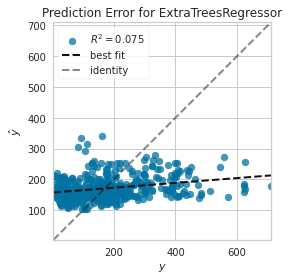

In [ ]:
plot_model(tuned_et, plot = 'error')

## Creating PyCaret experiment for data without cluster label

In [ ]:
train_data = pd.concat([X_train_impute_df, y_train], axis=1)
test_data = pd.concat([X_test_impute_df, y_test], axis=1)


In [ ]:
from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_exp = setup(train_data
                        , target='GSE_GWE',
                        train_size=1.0,
                        test_data= test_data,
                        preprocess=False, session_id=RANDOM_SEED,
                       log_experiment=True, experiment_name="water_depth_1")


,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/06/19 05:19:19 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_1' does not exist. Creating a new experiment.


In [ ]:
%matplotlib inline
#creating a model
lr = create_model('lr')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,60.5391,5620.6567,74.9710,-1.5227,1.1444,2.5886
1,49.3387,5548.7163,74.4897,-0.6424,1.0168,1.8340
2,61.2455,5839.9800,76.4198,-0.6195,0.9926,1.6280
3,118.8061,28076.1484,167.5594,-0.1898,1.3897,1.0325
4,96.4245,14653.2207,121.0505,-0.1081,1.1343,4.7910
5,98.9640,17177.8027,131.0641,0.0658,0.8439,1.1027
6,59.3626,6646.0552,81.5233,0.5908,0.6764,0.4034
7,93.7908,14339.1943,119.7464,-0.7675,0.9613,0.4945
8,149.1629,33760.9023,183.7414,-0.2025,0.8881,1.1453


In [ ]:
compare_models() #Time taken > 17m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,70.5179,10740.0180,97.2247,0.0540,0.7837,1.5393,11.3840
catboost,CatBoost Regressor,70.7887,11044.2826,98.6889,0.0071,0.7658,1.5316,59.9570
knn,K Neighbors Regressor,72.3936,11579.0293,102.3158,-0.0231,0.7836,1.3389,0.4710
lightgbm,Light Gradient Boosting Machine,72.2234,12082.0949,104.0247,-0.0865,0.7844,1.6298,1.8350
rf,Random Forest Regressor,73.4169,12195.5446,104.9810,-0.1185,0.7926,1.6145,17.7000
gbr,Gradient Boosting Regressor,76.1402,12038.4885,104.5773,-0.1513,0.8097,1.6620,5.4630
xgboost,Extreme Gradient Boosting,75.8291,12697.6439,105.8081,-0.1751,0.8008,1.5598,6.3740
par,Passive Aggressive Regressor,82.9517,14187.0734,111.4536,-0.2351,0.8758,1.3517,0.1990
huber,Huber Regressor,82.1170,14566.3943,112.6089,-0.2532,0.8856,1.4366,0.5450
ridge,Ridge Regression,85.3541,14136.0786,112.3464,-0.2633,0.9009,1.6376,0.0550


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53.0363,5126.2066,71.5975,-1.3008,1.1736,3.0000
1,30.0430,1500.0719,38.7308,0.5560,0.6725,1.0498
2,43.8292,2910.5393,53.9494,0.1929,0.8771,1.7781
3,94.2513,18941.7282,137.6290,0.1973,0.9518,1.1511
4,84.1569,13422.9810,115.8576,-0.0150,1.1178,5.0476
5,71.6312,13013.7122,114.0777,0.2923,0.6609,0.7204
6,52.9638,6682.1155,81.7442,0.5885,0.4385,0.3891
7,70.1110,8848.7840,94.0680,-0.0907,0.4725,0.4301
8,128.3566,26737.7562,163.5168,0.0477,0.7681,0.9291


In [ ]:
tuned_et  = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,65.8685,5821.9516,76.3017,-1.6131,1.3439,3.8286
1,41.1770,2422.3424,49.2173,0.2830,0.8510,1.4975
2,58.2190,4772.3281,69.0820,-0.3234,1.0675,2.2995
3,120.0881,25542.1140,159.8190,-0.0824,1.0346,1.5344
4,81.4949,11210.6813,105.8805,0.1522,1.0396,3.4871
5,88.3400,15814.7677,125.7568,0.1400,0.7301,0.8500
6,80.1744,13682.3834,116.9717,0.1575,0.5901,0.5309
7,78.5067,9748.8373,98.7362,-0.2017,0.4742,0.3573
8,148.1815,35467.8366,188.3291,-0.2633,0.8458,0.9400


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


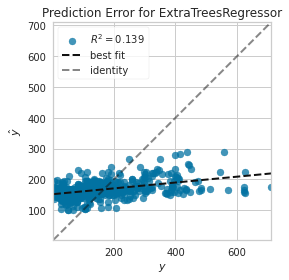

In [ ]:
plot_model(tuned_et, plot = 'error')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>